### Step 1: Loading Libraries

In [1]:
# imports
import pandas as pd
import numpy as np
import re
import spacy
from collections import Counter
import string
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

# User defined functions
import assUtils
importlib.reload(assUtils)
from assUtils import tweet_clean
from assUtils import build_vocabulary
from assUtils import encode_df
from assUtils import text_preprocesser

#pytorch imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error

### Step 1: Stemming, lemmatizing and stop word removal

In [ ]:

data_folder = "C:/Users/david/Documents/Masters/Semester2/COMP47650_Deep_Learning/Assignment/Dataset"
original_file_name = "/dataset(clean).csv"
original_file_location = data_folder + original_file_name
raw_tweets = pd.read_csv(original_file_location)
pp_tweets = text_preprocesser(raw_tweets, "Content")

pp_tweets_and_tags = pd.DataFrame()
pp_tweets_and_tags.loc[:,"label"] = raw_tweets["Emotion"]
pp_tweets_and_tags.loc[:,"tweet_text"] = pp_tweets

pp_data_location = data_folder + "/pp_tweets.csv"
pp_tweets_and_tags.to_csv(pp_data_location, index = False)


In [282]:
source_folder = 'C:/Users/david/Documents/Masters/Semester2/COMP47650_Deep_Learning/Assignment/Dataset'
file_name = "/pp_tweets.csv"
pp_data_location = source_folder + file_name
data = pd.read_csv(pp_data_location)
#data = data.loc[:1000,:].copy()


data = tweet_clean(data)
tok = spacy.load('en_core_web_sm') # loading spacy tokenizers
vocab2index, words, counts = build_vocabulary(data) # making a vocabulary
encode_df(data, vocab2index) # creating a column with a the word encodings
data.drop("tweet_text", axis = 1, inplace = True) #removing no longer needed text data

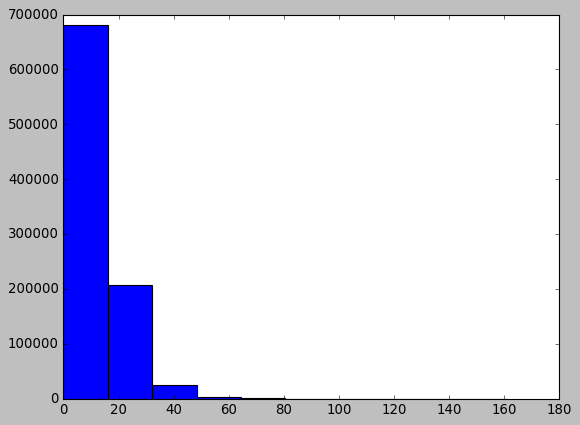

In [283]:
#mean sentence length
np.mean(data['tweet_length'])

import matplotlib.pyplot as plt
plt.hist(data['tweet_length'])
plt.show()


Visualizing the distribution of tweet lengths here.

Most tweets have a length less than 40.

Reducing the length of the scentence input into the model can decrease running time
Truncating at 40 words in a scentence will only lead to a small loss in data but a big increase in run time.


### Step 5: Making test, train and validation data

In [5]:
#data = pd.read_csv("data_pp.csv")

X = list(data['encoded'])
y = list(data['label'])

test_size = 0.2
valid_size = 0.2

from sklearn.model_selection import train_test_split # splitting the data into train, validation and test data
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = test_size, shuffle = True, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size = valid_size, shuffle = True, random_state = 0)

In [6]:
# Removing unnessesary items from memory
import gc
del data
#del pp_tweets_and_tags
#del raw_tweets
#del pp_tweets

gc.collect()

3355

In [8]:
from assUtils import ReviewsDataset
train_ds = ReviewsDataset(X_train, y_train)
valid_ds = ReviewsDataset(X_valid, y_valid)
test_ds = ReviewsDataset(X_test, y_test)

In [9]:

del X_train_full
del X_test
del y_train_full
del y_test
del X_train
del X_valid
del y_train
del y_valid
gc.collect()


6962

In [10]:
device = "cuda" if torch.cuda.is_available() else 'cpu' # setting the device to cuda if a GPU is present
device

'cuda'

### Word Embeddings

In [11]:

pretrained_embeddings_folder = 'C:/Users/david/Documents/Masters/Semester2/COMP47650_Deep_Learning/Assignment/PretrainedEmbeddings'
glove_file = "/glove.twitter.27B.200d.txt"
glove_file_location = pretrained_embeddings_folder + glove_file

word_vecs = assUtils.load_embedding_vectors(filename = glove_file_location)
pretrained_weights, vocab, vocab2index = assUtils.get_emb_matrix(word_vecs, counts)
vocab_size = len(words)

In [12]:
del word_vecs
gc.collect()

6395

Importing the RayTune compatible LSTM and GRU Class 

In [34]:
from assUtils import LSTM_pretrained_embeddings
from assUtils import GRU_pretrained_embeddings

In [86]:
def train_lstm_ray(config, checkpoint_dir = None):
    
    model = LSTM_pretrained_embeddings(
        vocab_size,
        hidden_dim = config['hidden_dim'],
        embedding_weights = pretrained_weights,
        num_layers = config['num_layers'],
        bidirectional = True,
        dropout_rate = config['dropout_rate'])
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    model.to(device)
    
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    criterion = F.cross_entropy
    optimizer = torch.optim.Adam(parameters, lr=config['lr'], weight_decay = config['weight_decay'], amsgrad = config['amsgrad'])
    
    #if checkpoint_dir:
    #    model_state, optimizer_state = torch.load(os.path.join(checkpoint_dir, "checkpoint"))
    #    model.load_state_dict(model_state)
    #    optimizer.load_state_dict(optimizer_state)
    
    train_dl = DataLoader(train_ds, batch_size = int(config['batch_size']), shuffle = True)
    valid_dl = DataLoader(valid_ds, batch_size = int(config['batch_size']), shuffle = True)
    
    epochs = config['epochs']
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        epoch_steps = 0
        
        for x_train, y_train, l_train in train_dl:
            x_train = x_train.long().to(device)
            y_train = y_train.long().to(device)
            y_pred_train = model(x_train, l_train) # getting the predictions
            optimizer.zero_grad() # gradients must be reset to 0 for each iteration, pyorch keeps them by default
            loss = criterion(y_pred_train, y_train)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_steps += 1
        
        
        model.eval()
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        
        for x_valid, y_valid, l_valid in valid_dl:
            with torch.no_grad():
                x_valid = x_valid.long().to(device)
                y_valid = y_valid.long().to(device)
                y_pred_valid = model(x_valid, l_valid)
                
                pred = torch.max(y_pred_valid,1)[1]
                correct += (pred == y_valid).float().sum()
                total += y_valid.shape[0]
                
                loss = criterion(y_pred_valid, y_valid)
                val_loss += loss.cpu().numpy()
                val_steps += 1
        
        #with tune.checkpoint_dir(epoch) as checkpoint_dir:
        #    path = os.path.join(checkpoint_dir, "checkpoint")
        #    torch.save((model.state_dict(), optimizer.state_dict()), path)
        
        tune.report(loss = (val_loss / val_steps), accuracy = (correct /total).item())
    print("Finished Testing")

In [15]:
def train_gru_ray(config, checkpoint_dir = None):
    
    model = GRU_pretrained_embeddings(
        vocab_size,
        hidden_dim = config['hidden_dim'],
        embedding_weights = pretrained_weights,
        num_layers = config['num_layers'],
        bidirectional = True,
        dropout_rate = config['dropout_rate'])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    model.to(device)
    
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    criterion = F.cross_entropy
    optimizer = torch.optim.Adam(parameters, lr=config['lr'], weight_decay = config['weight_decay'], amsgrad = config['amsgrad'])
    
    #if checkpoint_dir:
    #    model_state, optimizer_state = torch.load(os.path.join(checkpoint_dir, "checkpoint"))
    #    model.load_state_dict(model_state)
    #    optimizer.load_state_dict(optimizer_state)
    
    train_dl = DataLoader(train_ds, batch_size = int(config['batch_size']), shuffle = True)
    valid_dl = DataLoader(valid_ds, batch_size = int(config['batch_size']), shuffle = True)
    
    epochs = config['epochs']
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        epoch_steps = 0
        
        for x_train, y_train, l_train in train_dl:
            x_train = x_train.long().to(device)
            y_train = y_train.long().to(device)
            y_pred_train = model(x_train, l_train) # getting the predictions
            optimizer.zero_grad() # gradients must be reset to 0 for each iteration, pyorch keeps them by default
            loss = criterion(y_pred_train, y_train)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_steps += 1
        
        
        model.eval()
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        
        for x_valid, y_valid, l_valid in valid_dl:
            with torch.no_grad():
                x_valid = x_valid.long().to(device)
                y_valid = y_valid.long().to(device)
                y_pred_valid = model(x_valid, l_valid)
                
                pred = torch.max(y_pred_valid,1)[1]
                correct += (pred == y_valid).float().sum()
                total += y_valid.shape[0]
                
                loss = criterion(y_pred_valid, y_valid)
                val_loss += loss.cpu().numpy()
                val_steps += 1
        
        #with tune.checkpoint_dir(epoch) as checkpoint_dir:
        #    path = os.path.join(checkpoint_dir, "checkpoint")
        #    torch.save((model.state_dict(), optimizer.state_dict()), path)
        
        tune.report(loss = (val_loss / val_steps), accuracy = (correct /total).item())
    print("Finished Testing")

Importing the LSTM Training Function 

In [91]:
import ray
from ray import tune
from ray.tune import JupyterNotebookReporter
from ray.tune.schedulers import ASHAScheduler


config = {'hidden_dim':tune.grid_search([3,5,10]),
          'num_layers':tune.grid_search([1,2,3]),
          #'lr':tune.grid_search(list(np.linspace(0.0001,0.001,5))),
          'lr': tune.loguniform(1e-5, 1e-1),
          'weight_decay':tune.grid_search([0]),
          'amsgrad':tune.grid_search([False]),
          'batch_size':tune.grid_search([16,32,64,128]),
          'epochs':tune.grid_search([10,15]),
          'dropout_rate':tune.grid_search([0.2,0.5])
         }


num_samples=10
max_time_units = 200

scheduler = ASHAScheduler(
    metric="accuracy",
    mode="max",
    max_t=max_time_units,
    grace_period=1,
    reduction_factor=2)

reporter = JupyterNotebookReporter(
    overwrite = True,
    parameter_columns=list(config.keys()),
    metric_columns=["loss", "accuracy", "training_iteration"],
    max_report_frequency = 10)


In [92]:
#ray.shutdown()
#ray.init()
# run the two above lines when running this code for a second or third time
analysis_lstm = tune.run(train_lstm_ray,
                    config = config,
                    resources_per_trial={"cpu": 8,"gpu": 1},
                    #resources_per_trial={"gpu": .1},
                    scheduler = scheduler,
                    progress_reporter = reporter
                   )

Trial name,status,loc,hidden_dim,num_layers,lr,weight_decay,amsgrad,batch_size,epochs,dropout_rate,loss,accuracy,training_iteration
train_lstm_rayy_8a84e_00000,TERMINATED,,3,1,0.000792426,0,False,16,10,0.2,0.384311,0.840169,10
train_lstm_rayy_8a84e_00001,TERMINATED,,3,1,0.00109445,0,False,32,10,0.2,0.417635,0.82827,8
train_lstm_rayy_8a84e_00002,TERMINATED,,3,1,0.000391762,0,False,64,10,0.2,0.976184,0.544373,1
train_lstm_rayy_8a84e_00003,TERMINATED,,3,1,0.0749074,0,False,128,10,0.2,0.700338,0.63455,1
train_lstm_rayy_8a84e_00004,TERMINATED,,3,1,0.00146384,0,False,16,10,0.5,0.821236,0.61556,1
train_lstm_rayy_8a84e_00005,TERMINATED,,3,1,0.000200761,0,False,32,10,0.5,1.06511,0.443728,1
train_lstm_rayy_8a84e_00006,TERMINATED,,3,1,0.000495065,0,False,64,10,0.5,0.938676,0.564488,1
train_lstm_rayy_8a84e_00007,TERMINATED,,3,1,0.000749943,0,False,128,10,0.5,1.02244,0.485084,1
train_lstm_rayy_8a84e_00008,TERMINATED,,3,1,2.36055e-05,0,False,16,15,0.2,1.09894,0.349426,1
train_lstm_rayy_8a84e_00009,TERMINATED,,3,1,0.00205185,0,False,32,15,0.2,0.484202,0.798779,4


2021-04-22 21:10:24,619	INFO tune.py:450 -- Total run time: 28023.33 seconds (28016.94 seconds for the tuning loop).


In [93]:
# Writing the Hyper Parameters to a JSON file

best_config_lstm = analysis_lstm.get_best_config(metric = "accuracy", mode = "max")
import json
with open("best_config_lstm.json","w") as myfile:
    json.dump(best_config_lstm, myfile)
myfile.close()

with open("best_config_lstm.json","r") as myfile:
    best_config_lstm = json.loads(myfile.read())
myfile.close()

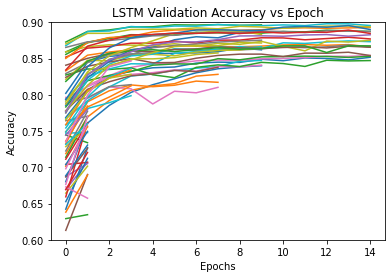

In [98]:
# Plotting the various trials from the hyperparameter tuning
import matplotlib.pyplot as plt
ax = None
dfs = analysis_lstm.trial_dataframes
fig = plt.figure()
for d in dfs.values():
    ax = d.accuracy.plot(ax = ax, legend = False)
    
    
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_ylim((0.6,0.9))
ax.set_title("LSTM Validation Accuracy vs Epoch");
fig.savefig("Figures/lstm_trials.png")

In [279]:
best_config_lstm

{'hidden_dim': 10,
 'num_layers': 2,
 'lr': 0.005892401628652007,
 'weight_decay': 0,
 'amsgrad': False,
 'batch_size': 64,
 'epochs': 10,
 'dropout_rate': 0.2}

In [270]:
#training the LSTM with the best config and getting some metrics(acuracy, f1, precision and recall) and its predictions

from assUtils import train_model

start_time = time()
lstm_metrics, ys_lstm = train_model(LSTM_pretrained_embeddings, config = best_config_lstm, vocab_size = vocab_size, pretrained_weights = pretrained_weights, train_ds = train_ds, valid_ds = test_ds)
print((time() - start_time)/60 , "minutes")

Total Completed 0.0
Total Completed 0.1
Total Completed 0.2
Total Completed 0.3
Total Completed 0.4
Total Completed 0.5
Total Completed 0.6
Total Completed 0.7
Total Completed 0.8
Total Completed 0.9
18.355479967594146 minutes


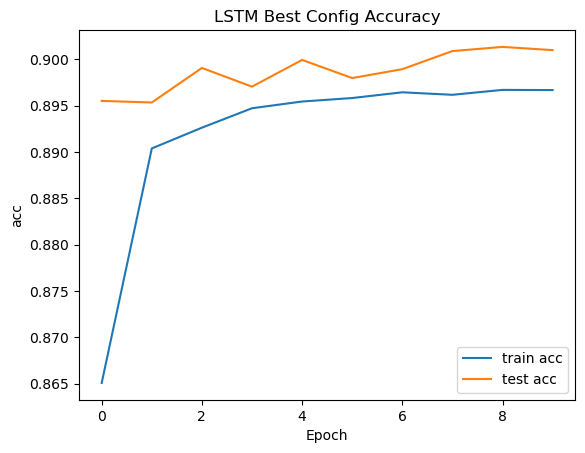

In [271]:
# Plotting the accuracy
from assUtils import plot_metric
plot_metric(lstm_metrics , title = "LSTM Best Config Accuracy", name = "lstm_acc")

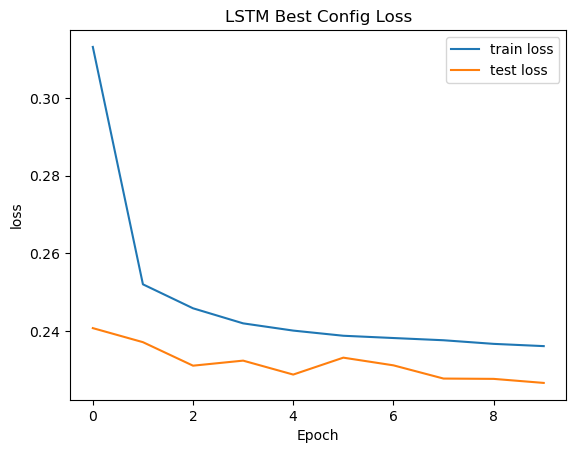

In [272]:
# plotting the loss 
plot_metric(lstm_metrics, "loss", title = "LSTM Best Config Loss", name = "lstm_loss")

LSTM Accuracy 0.9010010091918282
LSTM Precision 0.9054221950274256
LSTM Recall 0.901537306726791
LSTM F1 Score 0.902322088646295
Normalized confusion matrix
[[0.92 0.08 0.  ]
 [0.13 0.86 0.01]
 [0.05 0.02 0.93]]


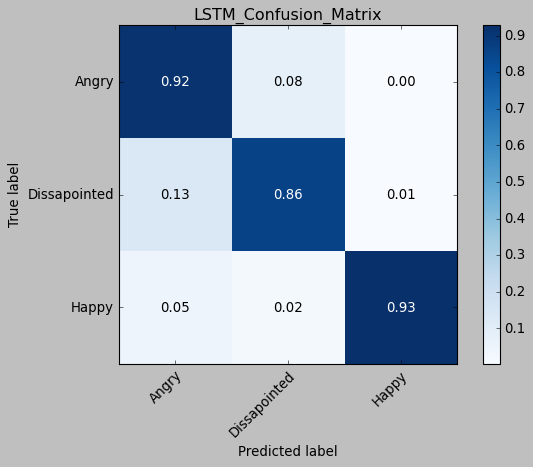

In [274]:
# Printing the results and getting a confusion matrix

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

importlib.reload(assUtils)
from assUtils import results

y_true_test = ys_lstm['y_true_test'].dropna()
y_pred_test = ys_lstm['y_pred_test'].dropna()

results(y_true_test, y_pred_test, "LSTM")

LSTM Accuracy 0.8966873960123285
LSTM Precision 0.9008879639241182
LSTM Recall 0.8972454094685118
LSTM F1 Score 0.8978709630041136
Normalized confusion matrix
[[0.91 0.08 0.  ]
 [0.14 0.85 0.01]
 [0.05 0.02 0.93]]


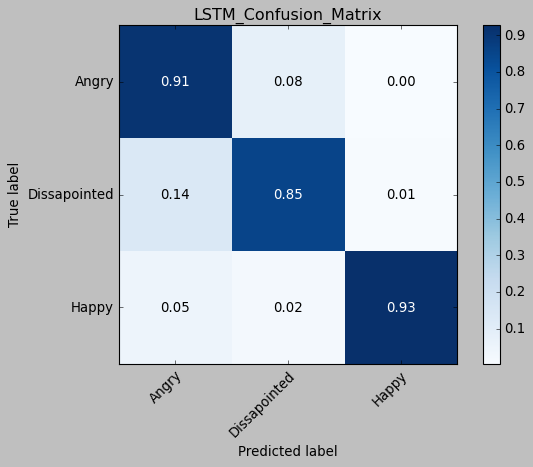

In [276]:
results(ys_lstm['y_true_train'], ys_lstm['y_pred_train'], "LSTM")

In [18]:
analysis_gru = tune.run(train_gru_ray,
                    config = config,
                    resources_per_trial={"cpu": 8,"gpu": 1},
                    scheduler = scheduler,
                    progress_reporter = reporter
                   )

Trial name,status,loc,hidden_dim,num_layers,lr,weight_decay,amsgrad,batch_size,epochs,dropout_rate,loss,accuracy,training_iteration
train_gru_ray_64067_00000,TERMINATED,,3,1,0.0160612,0,False,16,10,0.2,0.539529,0.777539,10
train_gru_ray_64067_00001,TERMINATED,,3,1,0.00525567,0,False,32,10,0.2,0.3875,0.841328,10
train_gru_ray_64067_00002,TERMINATED,,3,1,0.000190166,0,False,64,10,0.2,1.08564,0.378541,1
train_gru_ray_64067_00003,TERMINATED,,3,1,2.88091e-05,0,False,128,10,0.2,1.10455,0.342641,1
train_gru_ray_64067_00004,TERMINATED,,3,1,0.00406798,0,False,16,10,0.5,0.57904,0.758038,2
train_gru_ray_64067_00005,TERMINATED,,3,1,5.27821e-05,0,False,32,10,0.5,1.09592,0.358631,1
train_gru_ray_64067_00006,TERMINATED,,3,1,2.06889e-05,0,False,64,10,0.5,1.09786,0.363949,1
train_gru_ray_64067_00007,TERMINATED,,3,1,0.00374557,0,False,128,10,0.5,0.553837,0.756878,2
train_gru_ray_64067_00008,TERMINATED,,3,1,0.0228155,0,False,16,15,0.2,0.73047,0.703658,2
train_gru_ray_64067_00009,TERMINATED,,3,1,0.0227646,0,False,32,15,0.2,0.504064,0.796768,4


2021-04-22 08:11:48,445	INFO tune.py:450 -- Total run time: 24331.19 seconds (24313.60 seconds for the tuning loop).


In [247]:
best_config_gru = analysis_gru.get_best_config(metric = "accuracy", mode = "max")
with open("best_config_gru.json","w") as myfile:
    json.dump(best_config_gru, myfile)
myfile.close()

with open("best_config_gru.json","r") as myfile:
    best_config_gru = json.loads(myfile.read())
myfile.close()


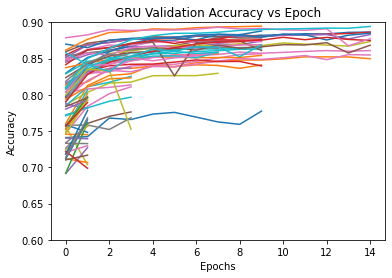

In [99]:
import matplotlib.pyplot as plt
ax = None
dfs = analysis_gru.trial_dataframes
fig = plt.figure()
for d in dfs.values():
    ax = d.accuracy.plot(ax = ax, legend = False)
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_ylim((0.6,0.9))
ax.set_title("GRU Validation Accuracy vs Epoch")
fig.savefig("Figures/gru_trials.png");

In [21]:
from time import time

In [248]:
start_time = time()
gru_metrics, ys_gru = train_model(GRU_pretrained_embeddings, config = best_config, vocab_size = vocab_size, pretrained_weights = pretrained_weights, train_ds = train_ds, valid_ds = test_ds)
print((time() - start_time)/60 , "minutes")

Total Completed 0.0
Total Completed 0.1
Total Completed 0.2
Total Completed 0.3
Total Completed 0.4
Total Completed 0.5
Total Completed 0.6
Total Completed 0.7
Total Completed 0.8
Total Completed 0.9
13.962990895907085 minutes


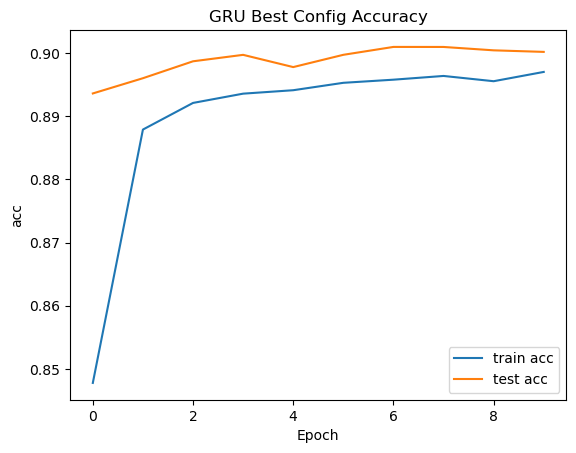

In [253]:
importlib.reload(assUtils)
from assUtils import plot_metric
plot_metric(gru_metrics, title = "GRU Best Config Accuracy", name = "gru_acc")

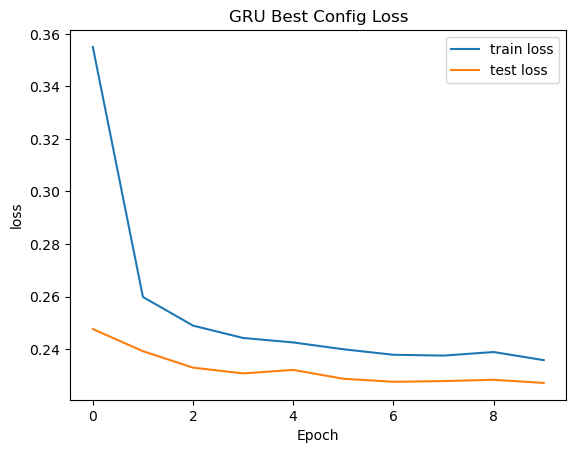

In [254]:
plot_metric(gru_metrics, metric = "loss",  title = "GRU Best Config Loss", name = "gru_loss")

GRU Accuracy 0.9001718353653547
GRU Precision 0.9056302107138223
GRU Recall 0.9008668588954915
GRU F1 Score 0.9014915217969071
Normalized confusion matrix
[[0.93 0.07 0.01]
 [0.15 0.85 0.01]
 [0.05 0.02 0.93]]


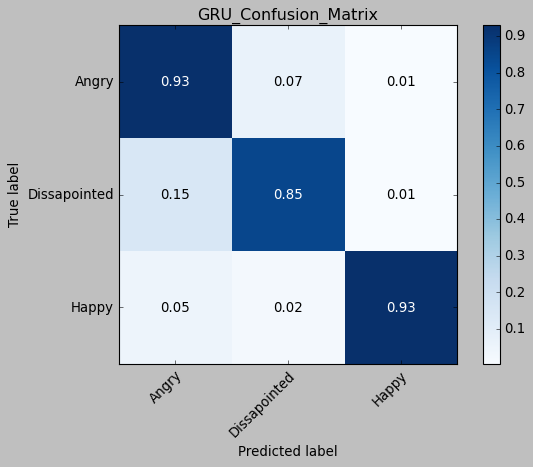

In [269]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

importlib.reload(assUtils)
from assUtils import results

y_true_test = ys_gru['y_true_test'].dropna()
y_pred_test = ys_gru['y_pred_test'].dropna()

results(y_true_test, y_pred_test, "GRU")

GRU Accuracy 0.8969993590268118
GRU Precision 0.9009775972769146
GRU Recall 0.8975562964906603
GRU F1 Score 0.8981401160269188
Normalized confusion matrix
[[0.91 0.08 0.01]
 [0.14 0.85 0.01]
 [0.05 0.02 0.93]]


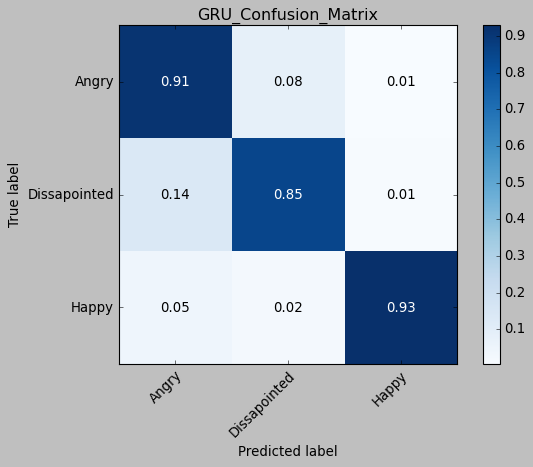

In [278]:
results(ys_gru['y_true_train'], ys_gru['y_pred_train'], "GRU")